##We configured the drive with API key from Kaggle (kaggle.json) which is used to authenticate our kaggle account when we downlaod the dataset(new-plant-disease-dataset).

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/drive/MyDrive/Kaggle_Data'

##we Mounted the google drive to save the dataset to drive once the zip file is downloaded.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pwd

'/content'

In [ ]:
!ls

kaggle.json  new-plant-diseases-dataset


In [ ]:
!mkdir new-plant-diseases-dataset
!mv new-plant-diseases-dataset.zip new-plant-diseases-dataset

In [ ]:
%cd new-plant-diseases-dataset

/content/drive/My Drive/Kaggle_Data/new-plant-diseases-dataset


In [ ]:
!ls

drive  sample_data


##Extracted the Dataset Zip file using Unzip command in to the colab VM storage.

In [ ]:
!unzip /content/drive/MyDrive/Kaggle_Data/new-plant-diseases-dataset/new-plant-diseases-dataset.zip

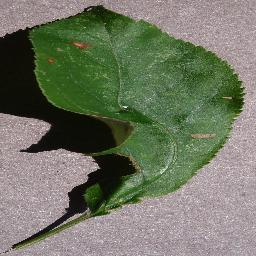

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img=cv2.imread('/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Black_rot/0090d05d-d797-4c99-abd4-3b9cb323a5fd___JR_FrgE.S 8727.JPG')
cv2_imshow(img)

##After downloading the dataset all the required libraries/modules are imported (or downloaded if required).

##TensorFlow-Hub is installed to import a pre-trained model.

In [ ]:
# Install TF Hub for TF2
!pip install 'tensorflow-hub == 0.5'

##All the required libraries for deep learning such as Tensorflow, Keras are imported.

In [ ]:
!pip install tensorflow==1.15

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers

##After extracting the dataset, we will set the path for train directory, validation directory, test directory accordingly for use with our model.

In [ ]:
data_dir = os.path.join('/content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'valid')

print(train_dir)

/content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train


In [ ]:
os.listdir(data_dir)

['valid', 'train']

In [ ]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"

In [ ]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))

total images for training : /content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train : 70295files
total images for validation : /content/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid : 17572files


##We stored the deatils of different class names(all 38 plant diaseases) available in the form of a list.

In [ ]:
classes = ['Apple scab', 'Apple Black rot', 'Apple Cedar rust', 'Apple healthy', 
           'Blueberry healthy','Cherry healthy','Cherry Powdery mildew','Corn Cercospora Gray leaf spot',
           'Corn Common rust','Corn healthy','Corn Northern Leaf Blight',  'Grape Black rot','Grape Esca Black Measles',
           'Grape healthy',  'Grape Leaf blight Isariopsis','Orange Haunglongbing Citrus greening',
           'Peach Bacterial spot', 'Peach healthy','Pepper bell Bacterial spot', 'Pepper bell healthy', 
           'Potato Early blight', 'Potato healthy','Potato Late blight', 'Raspberry healthy', 'Soybean healthy', 
           'Squash Powdery mildew','Strawberry healthy','Strawberry Leaf scorch', 'Tomato Bacterial spot', 
           'Tomato Early blight','Tomato healthy', 'Tomato Late blight', 'Tomato Leaf Mold','Tomato Septoria leaf spot',
           'Tomato Two spotted spider mite', 'Tomato Target Spot','Tomato mosaic virus', 'Tomato Yellow Leaf Curl Virus']

In [ ]:
#Set Batch Size

In [ ]:
IMAGE_SHAPE = (224, 224)

BATCH_SIZE = 64 #@param {type:"integer"}

##The batch size is set as 64 and images are processed to have a standard size of (224,224) to match the size required by the pre-trained model used for our purpose.
##Data augmentation like rotation, shift, shear are performed to have a variety of test cases without the need for larger dataset. 



In [ ]:
 #Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)
#https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4

Found 17572 images belonging to 38 classes.
Found 70295 images belonging to 38 classes.


##Model

In [ ]:
import tensorflow as tf

In [ ]:
print(tf.__version__)

1.15.0


##Inorder to create our deep learning model, TensorFlow-Hub is used to download a pre-trained model(mobilenet_v2)for transfer learning. We use this pre-trained model as feature extractor and use these features for decision making using Dense Layers.
##During training only the final decision layer (Dense Layer) is trained, the pre-trained model is not trainable. It just acts as a feature extractor.

In [ ]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", 
                 output_shape=[1280],
                 trainable=False),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


##Other parametrs of the model such as learning rate, optimizer, loss function to be used while training are also configured.

In [ ]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])

##The model is trained according to the parameters configured by using the data we processed and augmented earlier. The model is trained for 10 epochs.

In [ ]:
EPOCHS=10 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/10
1098/1098 [==============================] - 1035s 943ms/step - loss: 0.7253 - acc: 0.6747 - val_loss: 0.3062 - val_acc: 0.9017
Epoch 2/10
1098/1098 [==============================] - 961s 876ms/step - loss: 0.4557 - acc: 0.8489 - val_loss: 0.2667 - val_acc: 0.9128
Epoch 3/10
1098/1098 [==============================] - 924s 842ms/step - loss: 0.4131 - acc: 0.8628 - val_loss: 0.2189 - val_acc: 0.9275
Epoch 4/10
1098/1098 [==============================] - 923s 840ms/step - loss: 0.3884 - acc: 0.8690 - val_loss: 0.2345 - val_acc: 0.9226
Epoch 5/10
1098/1098 [==============================] - 891s 812ms/step - loss: 0.3787 - acc: 0.8774 - val_loss: 0.2303 - val_acc: 0.9226
Epoch 6/10
1098/1098 [==============================] - 906s 825ms/step - loss: 0.3644 - acc: 0.8776 - val_loss: 0.2189 - val_acc: 0.9277
Epoch 7/10
1098/1098 [==============================] - 910s 829ms/step - loss: 0.3555 - acc: 0.8834 - val_loss: 0.2102 - val_acc: 0.9302
Epoch 8/10
1098/1098 [===========

##The Confusion Matrix is generated for the model trained based on validation data using pre-defined function from sklearn metrics.

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report

predictions = model.predict_generator(validation_generator,  17572 // BATCH_SIZE+1)

y_pred = np.argmax(predictions, axis=1)

true_classes = validation_generator.classes

class_labels = list(validation_generator.class_indices.keys())   

print(class_labels)

print(confusion_matrix(validation_generator.classes, y_pred))

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

##Similarly, Classification Report is also created using classification_report method from sklearn.

In [ ]:
report = classification_report(true_classes, y_pred, target_names=class_labels)
print(report)

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.91      0.95      0.93       504
                                 Apple___Black_rot       0.95      0.97      0.96       497
                          Apple___Cedar_apple_rust       0.98      0.96      0.97       440
                                   Apple___healthy       0.97      0.97      0.97       502
                               Blueberry___healthy       0.98      0.96      0.97       454
          Cherry_(including_sour)___Powdery_mildew       0.99      0.98      0.98       421
                 Cherry_(including_sour)___healthy       0.99      0.98      0.99       456
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.86      0.90       410
                       Corn_(maize)___Common_rust_       0.98      1.00      0.99       477
               Corn_(maize)___Northern_Leaf_Blight       0.89      0.95      0.

In [ ]:
conf_mat = confusion_matrix(validation_generator.classes, y_pred)

In [ ]:
import numpy as np
import pandas as pd

df = pd.DataFrame(data=conf_mat)
df.to_csv('outfile.csv', sep=' ', header=False,index=False)

In [ ]:
model.metrics_names

['loss', 'acc']

##Using Matplotlib we plot the Accuracy and Loss for each epoch using the training history saved.

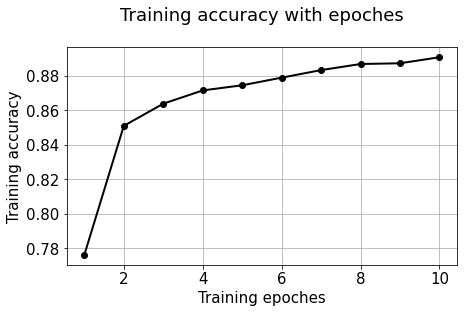

In [ ]:
import matplotlib.pylab as plt
import numpy as np
plt.figure(figsize=(7,4))
plt.plot([i+1 for i in range(EPOCHS)],history.history['acc'],'-o',c='k',lw=2)
plt.grid(True)
plt.title("Training accuracy with epoches\n",fontsize=18)
plt.xlabel("Training epoches",fontsize=15)
plt.ylabel("Training accuracy",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

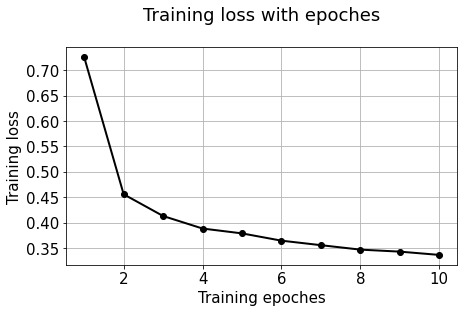

In [ ]:
plt.figure(figsize=(7,4))
plt.plot([i+1 for i in range(EPOCHS)],history.history['loss'],'-o',c='k',lw=2)
plt.grid(True)
plt.title("Training loss with epoches\n",fontsize=18)
plt.xlabel("Training epoches",fontsize=15)
plt.ylabel("Training loss",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

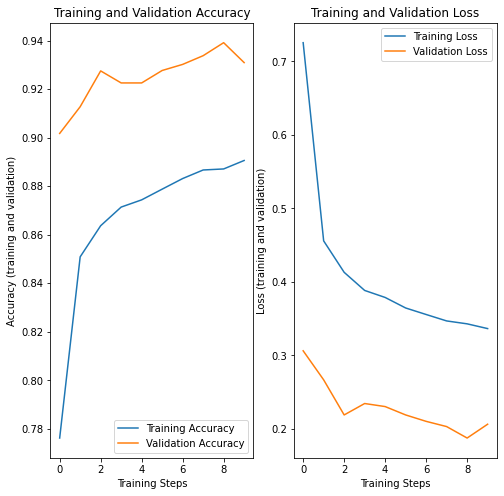

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Kaggle_Data/model.h5')

In [ ]:
import json

In [ ]:
np.save('/content/drive/MyDrive/Kaggle_Data/history.npy',history.history)